# Estimating thefts using XGBoost

In this notebook we will apply the XGBoost algoritm to model the expected criminality levels when a certain event did not occur. In Chicago there is an annual festival during which many thefts happen. The question is how many (arrests for) theft can be attributed to this festival.

Theft numbers are treated as time series. The dates of the festival are removed from the data, using surrounding points, we model the number of thefts that are expected to happen when the event never took place. If a model is trained on data in which the festival dates are not present, it will not learn anything about this festival. The model is then applied to the festival dates.

In (Wang, 2022)* the authors describe a method of timeseries forecasting using XGBoost. They do this by turning forecasting into a supervised learning problem. Given a timeseries $X_t$, one can regress $X_t$ as a function of its previous values:

$$X_t = f(X_{t-1},\dots, X_{t-h})$$

where $f$ is a function made of boosted trees. The idea behind this notebook is to extend this idea to predicting values between two datapoints:

$$X_t = f(X_{t-h_1},\dots, X_{t+h_2})$$

Or in this special case where the festival lasts multiple days, we want to impute multiple values of the time series. Let $T={\tau_a,\dots,\tau_b}$ be the indices time series points of multiple days: we compute for $\tau_0\in T$ the number of thefts according to

$$X_{\tau_0} = f(X_{\tau_a-h_1},\dots, X_{\tau_a-1}, \dots X_{\tau_b+1},\dots, X_{\tau_b+h_2})$$

Without too many specific details we continue with the analysis.

* https://ieeexplore.ieee.org/abstract/document/9058617

Note that the goal of this small project is *not* to find the best model, it about showcasing an interpolation method using XGBoost. Therefore we will not be performing hyperparameter tuning and use the default parameters of the model.

In [3]:
from Chicagodata import Chicago

import pandas as pd
import numpy as np
import seaborn as sns

Loading the crime data from Chicago

In [4]:
data = Chicago()

Some EDA. It appears that at latitude/longitude -87.615/41.885 the most thefts occur. Lets try to visualise this

In [49]:
df = data.data

(df.groupby(["Longitude", "Latitude"])['Count']
 .sum()
 .sort_values(ascending=False)
 .reset_index()
 .head()
)

,Longitude,Latitude,Count
0,-87.615,41.885,87728.0
1,-87.645,41.885,55709.0
2,-87.645,41.915,43245.0
3,-87.675,41.915,41199.0
4,-87.645,41.945,34314.0


Especially in latitude/longitude 41.885/-87.615 stands out. 

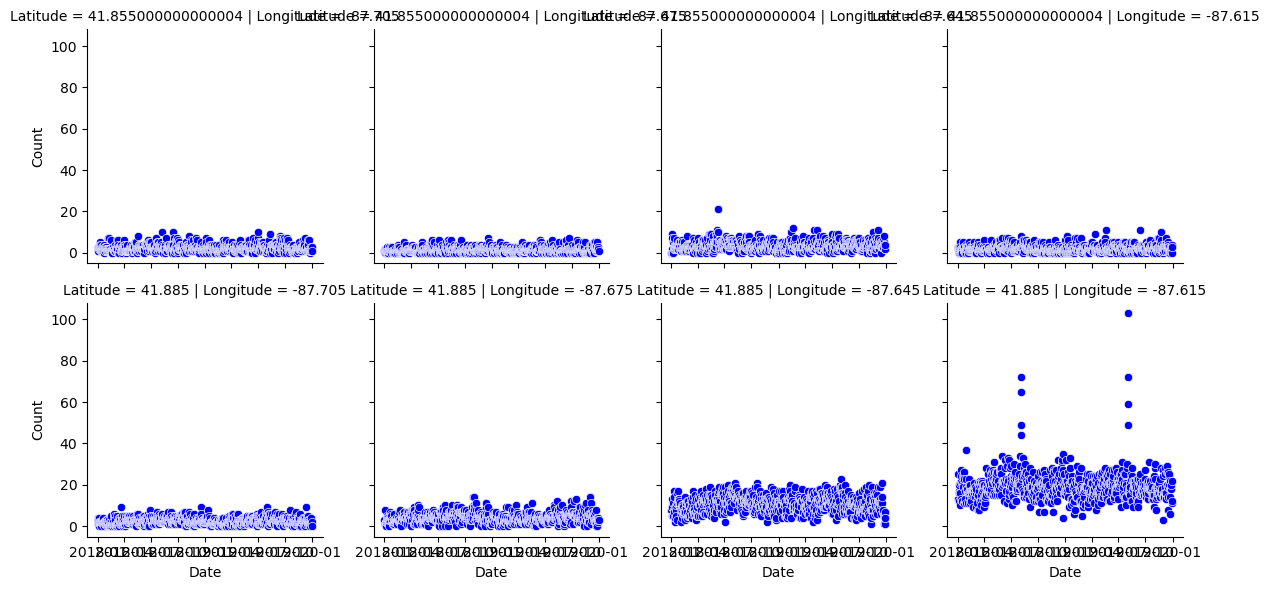

In [95]:
df_locations = (df
                .query("(41.855<=Latitude) & (Latitude<=41.885)")
                .query("(-87.705<=Longitude) & (Longitude<=-87.615)")
                .query("Date.dt.year>=2018")
               )

df_locations = df_locations.groupby(["Longitude", "Latitude", "Date"]).sum().reset_index()

g = sns.FacetGrid(df_locations, col='Longitude', row='Latitude')
g.map(sns.scatterplot, "Date", "Count", color="b")

It turns out there is an annual festival at the coastal area of the city center at the start of august to which we may relate the increased numbers of theft. A quick search results in news articles supporting this claim. We will use XGBoost to estimate the number of thefts that can be attributed to the festival. This algorithm may be a little too powerful for the purpose, but it is fun.

<Axes: xlabel='Date', ylabel='Count'>

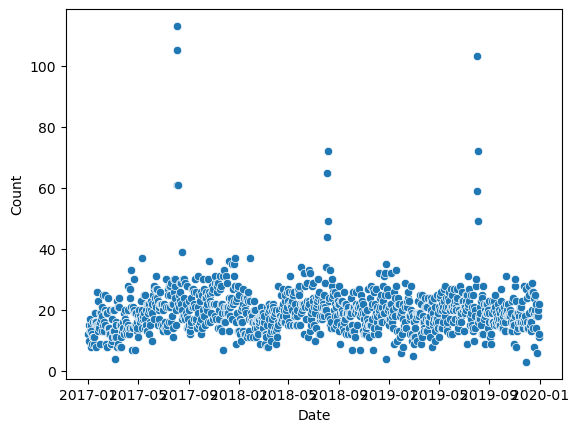

In [96]:
df_locations = df[(df["Longitude"]==-87.615) & (df["Latitude"]==41.885) & (df["Date"].dt.year>=2017)]

df_locations = (df_locations.groupby(["Longitude", "Latitude", "Date"])["Count"]
                .sum()
                .reset_index()
               )

sns.scatterplot(x="Date", y="Count", data=df_locations)

Filling a series of 7 days, ranging from 1st to 7th of august 2019 
For interpolation, we use a whole week before and after the masked dates. Because the festival returns annually, the theftdata needs to be removed for each year. Otherwise the model picks up the pattern and imposes it on the 2019 data which we are interested in. This is done automatically in the Chicago class.

In [76]:
fill_days = 7
with_number = 7
first_date_interval = pd.to_datetime('8-1-2019')

The model is trained. Removing the right dates, turning the timeseries imputation into a supervised learning problem is all done within the Chicago class. For further details, see the script Chicagodata.py. In order to estimate the number of thefts attributable to the festival in 2019, we need to train the model in data where the festival does not exist. To do so, we remove the first week of August in *every* year. All this is done in the class.

In [77]:
data.fit_predict_xgb_model(first_date_interval, fill_days, with_number)

Computing data_predict
Computing data_train
Training model
Computing prediction


The blue points are observed numbers of thefts and the red points are predictions/imputations of the XGBoost model. Note that the blue points are much more dispersed than the red points. This is because the blue points are realisations of a Poisson random variable, whereas the XGBoost model predicts *means* of a Poisson variable. 

The bottom left plot is where the festival takes place, as seen by the blue dots shooting out of the rest.

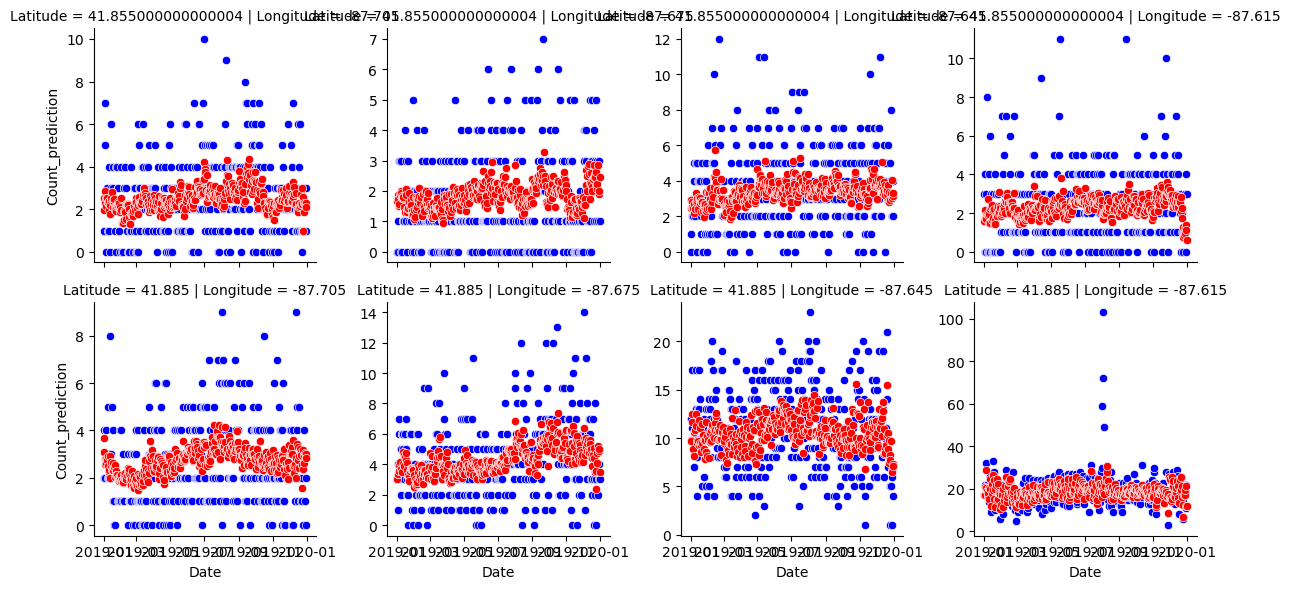

In [78]:
data_agg = data.data_predict
data_agg = data_agg[(41.855 <= data_agg["Latitude"]) & (data_agg["Latitude"] <= 41.885)]
data_agg = data_agg[(-87.705 <= data_agg["Longitude"]) & (data_agg["Longitude"] <= -87.615)]
data_agg = data_agg[data_agg["Date"].dt.year >= 2019]

g = sns.FacetGrid(data_agg, col='Longitude', row='Latitude', sharey=False)
g.map(sns.scatterplot, "Date", "Count", color="b")
g.map(sns.scatterplot, "Date", "Count_prediction", color="r")

In [79]:
startdate = pd.to_datetime('8-1-2019')
dates = pd.date_range(start=startdate, end=startdate+pd.DateOffset(days=3))

data_festival = data_agg[data_agg["Date"].isin(dates)]
idx_location = (data_festival["Latitude"]==41.885) & (data_festival["Longitude"]==-87.615)
data_festival = data_festival[idx_location]

np.sum(data_festival["Count"] - data_festival["Count_prediction"])

211.42854595184326

From here, we conclude that about 211 theft arrests are attributable to the 2019 edition of the festival.